In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
%matplotlib inline
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from plotnine import ggplot, aes, geom_histogram, geom_density, geom_qq, facet_wrap

from plotnine import *
import matplotlib.dates as mdates

In [2]:
def load_excel_data(file_path: str) -> pd.DataFrame:
    """Load data from an Excel file.

    Args:
        file_path: Path to the Excel file.

    Returns:
        DataFrame containing the loaded data.
    """
    df = pd.read_excel(file_path)
    print(df)
    return df

### 1.- Input de datos

In [3]:
file_path = r"E:\9_Desarrollo\UDD\Analisis_de_Datos\Notebook\Q_Medio_Mensual_input.xlsx"
df_input = load_excel_data(file_path)

         Origen      Fecha  Qmedio_mensual_l/s
0      ARPES-01 2014-01-01            6.658555
1      ARPES-01 2014-02-01            7.717431
2      ARPES-01 2014-03-01            7.663063
3      ARPES-01 2014-04-01            7.573851
4      ARPES-01 2014-05-01            5.465879
...         ...        ...                 ...
41221   XP17-05 2024-06-01            0.274481
41222   XP17-05 2024-08-01            0.070146
41223   XP17-05 2024-09-01            0.100827
41224   XP17-05 2024-10-01            0.841751
41225   XP17-05 2024-12-01            0.211238

[41226 rows x 3 columns]


In [4]:
df_input

,Origen,Fecha,Qmedio_mensual_l/s
0,ARPES-01,2014-01-01,6.658555
1,ARPES-01,2014-02-01,7.717431
2,ARPES-01,2014-03-01,7.663063
3,ARPES-01,2014-04-01,7.573851
4,ARPES-01,2014-05-01,5.465879
...,...,...,...
41221,XP17-05,2024-06-01,0.274481
41222,XP17-05,2024-08-01,0.070146
41223,XP17-05,2024-09-01,0.100827
41224,XP17-05,2024-10-01,0.841751


In [5]:
# Asegurarse de que la columna 'Fecha' esté en formato datetime
df_input['Fecha'] = pd.to_datetime(df_input['Fecha'])

df_input.head()

,Origen,Fecha,Qmedio_mensual_l/s
0,ARPES-01,2014-01-01,6.658555
1,ARPES-01,2014-02-01,7.717431
2,ARPES-01,2014-03-01,7.663063
3,ARPES-01,2014-04-01,7.573851
4,ARPES-01,2014-05-01,5.465879


In [6]:
df_train = df_input[['Origen', 'Fecha','Qmedio_mensual_l/s']].copy()
df_train=df_train.rename(columns={'Origen':'Pozo', 'Fecha':'Fecha','Qmedio_mensual_l/s':'Q_medio_mensual_l/s'})
df_train.head()

,Pozo,Fecha,Q_medio_mensual_l/s
0,ARPES-01,2014-01-01,6.658555
1,ARPES-01,2014-02-01,7.717431
2,ARPES-01,2014-03-01,7.663063
3,ARPES-01,2014-04-01,7.573851
4,ARPES-01,2014-05-01,5.465879


### 2.- Descomposición de las Series Temporales mediante STL

In [7]:
# Crear un nuevo DataFrame para guardar los resultados
df_result = pd.DataFrame()

#Parámetro para STL
PeriodoSTL = 12
Seasonal = 13  #Debe ser impar mayor a 3


# Iterar por cada pozo
for pozo in df_train['Pozo'].unique():
    # Filtrar los datos por pozo
    df_temp = df_train[df_train['Pozo'] == pozo]

    if not df_temp.empty:
        # Aplicar STL y guardar los resultados en el DataFrame
        stl = STL(df_temp['Q_medio_mensual_l/s'], period= PeriodoSTL, seasonal=Seasonal) 
        result = stl.fit()

        # Guardar los componentes de la descomposición STL en el DataFrame
        df_temp['Trend'] = result.trend
        df_temp['Seasonal'] = result.seasonal
        df_temp['Resid'] = result.resid
        df_temp['Ruido'] = df_temp['Resid'] + df_temp['Seasonal']  # Agregar el campo 'Ruido'
  
        # Juntar los resultados de cada iteración
        df_result = pd.concat([df_result, df_temp])

# Mostrar los primeros registros del resultado
df_result.head()

,Pozo,Fecha,Q_medio_mensual_l/s,Trend,Seasonal,Resid,Ruido
0,ARPES-01,2014-01-01,6.658555,6.975376,-0.112310,-0.204510,-0.316821
1,ARPES-01,2014-02-01,7.717431,7.011750,0.255092,0.450589,0.705682
2,ARPES-01,2014-03-01,7.663063,7.050837,0.238553,0.373673,0.612226
3,ARPES-01,2014-04-01,7.573851,7.092853,0.036364,0.444635,0.480999
4,ARPES-01,2014-05-01,5.465879,7.137536,-0.865926,-0.805732,-1.671657


In [8]:
df_result.shape

(41226, 7)

In [9]:
#Se indica si se quiere considerar el Ruido como la suma de Estacionalidad y Residuo, o solo como Residuo, o solo considerar el caudal
#df_result['Ruido'] = df_result['Resid'] + df_result['Seasonal']
#df_result['Ruido'] = df_result['Resid']
#df_result['Ruido'] = df_result['Caudal (L/s)']
df_result.head()

,Pozo,Fecha,Q_medio_mensual_l/s,Trend,Seasonal,Resid,Ruido
0,ARPES-01,2014-01-01,6.658555,6.975376,-0.112310,-0.204510,-0.316821
1,ARPES-01,2014-02-01,7.717431,7.011750,0.255092,0.450589,0.705682
2,ARPES-01,2014-03-01,7.663063,7.050837,0.238553,0.373673,0.612226
3,ARPES-01,2014-04-01,7.573851,7.092853,0.036364,0.444635,0.480999
4,ARPES-01,2014-05-01,5.465879,7.137536,-0.865926,-0.805732,-1.671657


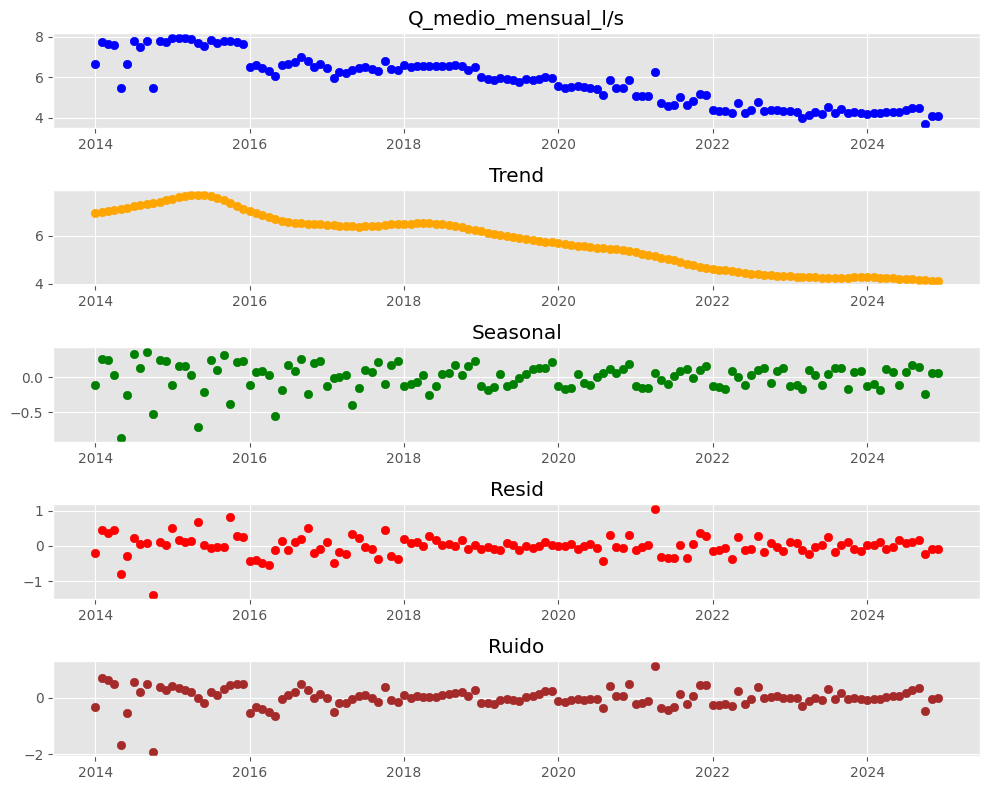

In [12]:
#Graficar descomposición STL

# Activa el estilo 'ggplot'
plt.style.use('ggplot')

#Seleccionar pozo
Pozo_selec='ARPES-01'
df_result_pozo = df_result[df_result['Pozo'] == Pozo_selec]

plt.figure(figsize=(10, 8))

#Graficar la serie original
plt.subplot(5, 1, 1)
plt.scatter(df_result_pozo['Fecha'], df_result_pozo['Q_medio_mensual_l/s'], label='Caudal', color='blue')   
plt.title('Q_medio_mensual_l/s')
plt.grid(True)

#Graficar la tendencia
plt.subplot(5, 1, 2)
plt.scatter(df_result_pozo['Fecha'], df_result_pozo['Trend'], label='Trend', color='orange')
plt.title('Trend')
plt.grid(True)

#Graficar la estacionalidad
plt.subplot(5, 1, 3)
plt.scatter(df_result_pozo['Fecha'], df_result_pozo['Seasonal'], label='Seasonal', color='green')
plt.title('Seasonal')
plt.grid(True)

# Graficar los residuos
plt.subplot(5, 1, 4)
plt.scatter(df_result_pozo['Fecha'], df_result_pozo['Resid'], label='Resid', color='red')
plt.title('Resid')
plt.grid(True)

# Graficar Q-T
plt.subplot(5, 1, 5)
plt.scatter(df_result_pozo['Fecha'], df_result_pozo['Ruido'], label='Ruido', color='brown')
plt.title('Ruido')
plt.grid(True)

#Ajustar el layout para evitar la superposición
plt.tight_layout()

#Mostrar la gráfica
plt.show()

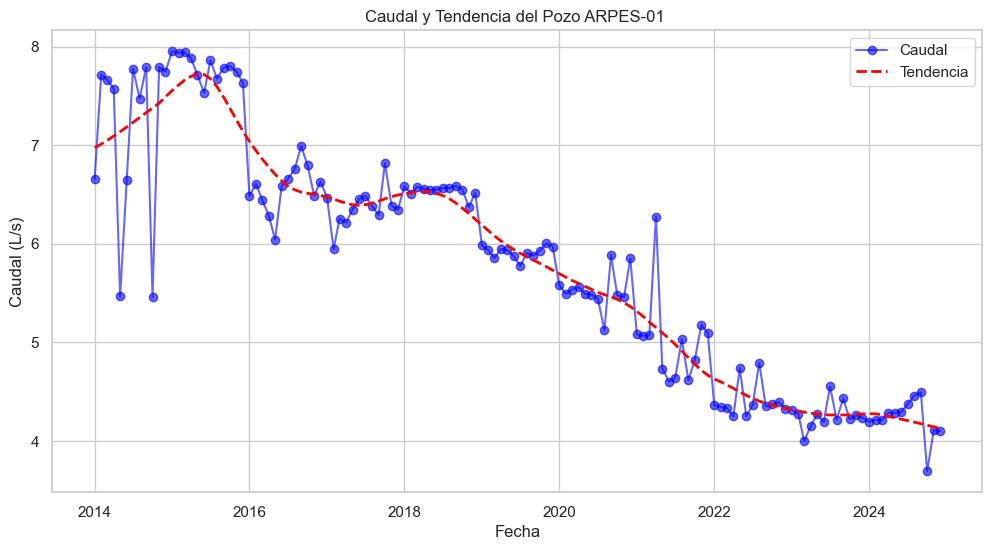

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Activa el estilo 'seaborn'
sns.set(style='whitegrid')

# Seleccionar pozo
Pozo_selec = 'ARPES-01'
df_result_pozo = df_result[df_result['Pozo'] == Pozo_selec]

plt.figure(figsize=(12, 6))

# Graficar el caudal original
plt.plot(df_result_pozo['Fecha'], df_result_pozo['Q_medio_mensual_l/s'], label='Caudal', color='blue', marker='o', linestyle='-', alpha=0.6)

# Graficar la tendencia
plt.plot(df_result_pozo['Fecha'], df_result_pozo['Trend'], label='Tendencia', color='red', linestyle='--', linewidth=2)

# Añadir etiquetas y título
plt.title(f'Caudal y Tendencia del Pozo {Pozo_selec} ')
plt.xlabel('Fecha')
plt.ylabel('Caudal (L/s)')  # Unidades del eje Y
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

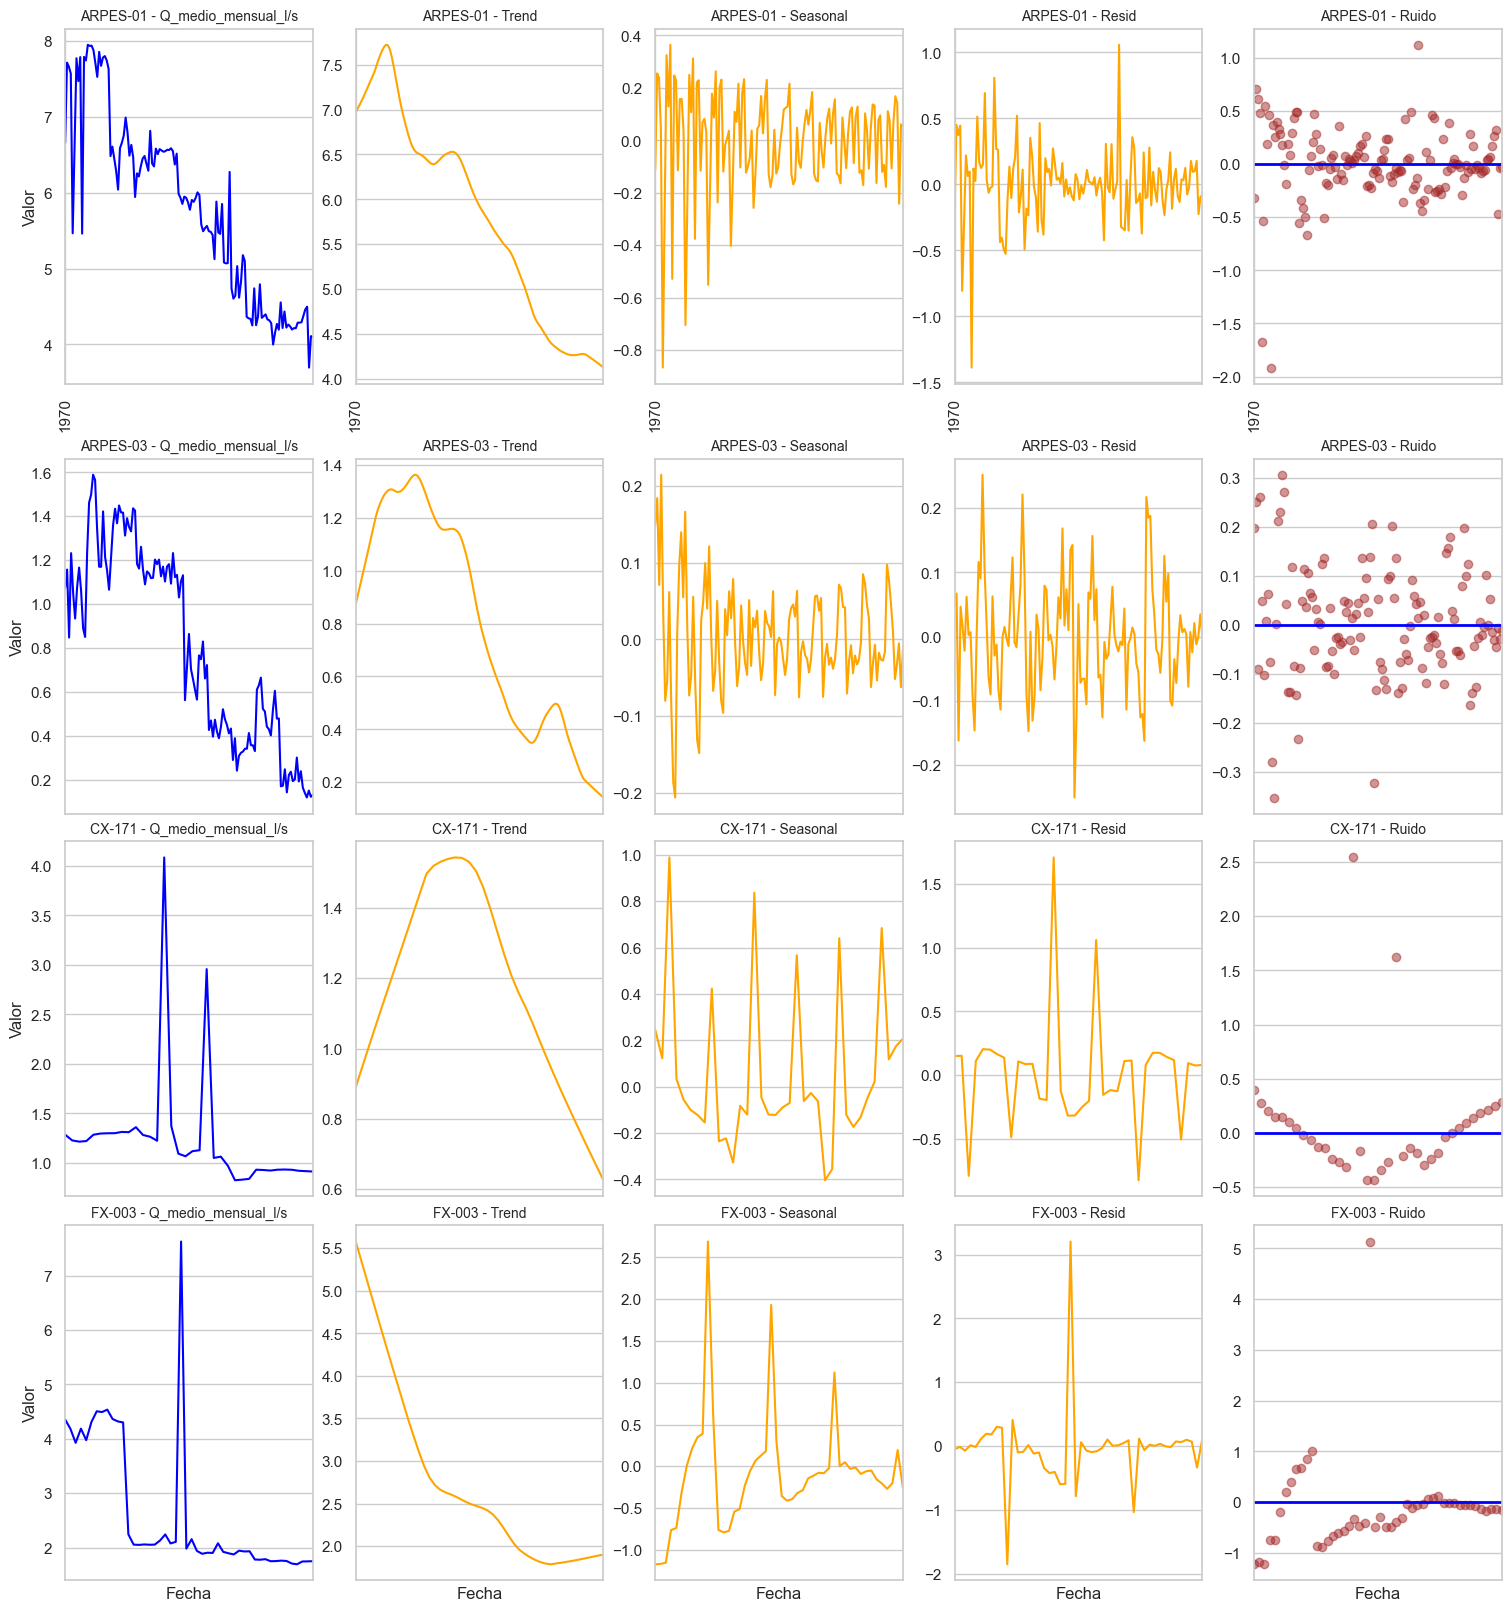

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np

# Activa el estilo 'seaborn'
sns.set(style='whitegrid')

# Lista de pozos a graficar 
pozos = ['ARPES-01','ARPES-03','CX-171', 'FX-003']

# Define el tamaño de la figura para que cada subplot tenga un aspecto más proporcionado
fig_width = 15  # Ancho de la figura en pulgadas
fig_height_per_row = 4  # Altura por cada fila de subplots en pulgadas

# Crear una figura y un conjunto de subplots
fig, axes = plt.subplots(nrows=len(pozos), ncols=5, figsize=(fig_width, fig_height_per_row * len(pozos)), constrained_layout=True)

# Iterar sobre cada pozo y crear los gráficos
for i, pozo in enumerate(pozos):
    # Filtramos por el pozo actual
    df_pozo = df_result[df_result['Pozo'] == pozo]

    # Graficar cada componente en su propio subplot
    for j, component in enumerate(['Q_medio_mensual_l/s', 'Trend', 'Seasonal', 'Resid', 'Ruido']):
        if component == 'Ruido':
            # Para los residuos, usamos un gráfico de puntos y agregamos la línea horizontal en el cero
            axes[i, j].scatter(df_pozo.index, df_pozo[component], alpha=0.5, color='brown')
            axes[i, j].axhline(0, color='blue', linewidth=2)  # Línea horizontal en el cero
        else:
            color = 'blue' if component == 'Q_medio_mensual_l/s' else 'orange'
            axes[i, j].plot(df_pozo.index, df_pozo[component], color=color)
        
        axes[i, j].set_title(f'{pozo} - {component}', fontsize=10)

        # Configuramos el eje x para mostrar solo los años correspondientes a los datos
        axes[i, j].xaxis.set_major_locator(mdates.YearLocator())
        axes[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        # Rotar las fechas a vertical
        for label in axes[i, j].get_xticklabels():
            label.set_rotation(90)

        # Ajustar los límites del eje x para que coincidan con los datos
        fecha_min = df_pozo.index.min()
        fecha_max = df_pozo.index.max()
        if np.isfinite(fecha_min) and np.isfinite(fecha_max):
            axes[i, j].set_xlim([fecha_min, fecha_max])

        # Añadir etiquetas a los ejes
        if j == 0:
            axes[i, j].set_ylabel('Valor')
        if i == len(pozos) - 1:
            axes[i, j].set_xlabel('Fecha')

# Ajustar automáticamente los parámetros del subplot para que encaje en el área de la figura
plt.show()

In [22]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41226 entries, 0 to 41225
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Pozo                 41226 non-null  object        
 1   Fecha                41226 non-null  datetime64[ns]
 2   Q_medio_mensual_l/s  41226 non-null  float64       
 3   Trend                41226 non-null  float64       
 4   Seasonal             41226 non-null  float64       
 5   Resid                41226 non-null  float64       
 6   Ruido                41226 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 2.5+ MB


In [23]:
df_result.head()

,Pozo,Fecha,Q_medio_mensual_l/s,Trend,Seasonal,Resid,Ruido
0,ARPES-01,2014-01-01,6.658555,6.975376,-0.112310,-0.204510,-0.316821
1,ARPES-01,2014-02-01,7.717431,7.011750,0.255092,0.450589,0.705682
2,ARPES-01,2014-03-01,7.663063,7.050837,0.238553,0.373673,0.612226
3,ARPES-01,2014-04-01,7.573851,7.092853,0.036364,0.444635,0.480999
4,ARPES-01,2014-05-01,5.465879,7.137536,-0.865926,-0.805732,-1.671657


### 3.- Detectar Outliers con el Metodo Filtro Hampel

In [24]:
import numpy as np
import pandas as pd

# Definir la función hampel_filter mejorada
def hampel_filter(ts, window_size=7, n_sigmas=2, imputation=True):
    ts = np.array(ts)  # Convertir la serie a un array de numpy
    n = len(ts)
    new_ts = ts.copy()
    k = 1.4826  # factor de normalización para la mediana absoluta de las desviaciones
    indices = []

    for i in range(n):
        start = max(0, i - window_size)
        end = min(n, i + window_size + 1)
        window = ts[start:end]
        median = np.median(window)
        diff = np.abs(window - median)
        MAD = np.median(diff)
        
        if MAD == 0:
            MAD = np.median(diff)  # Si MAD es 0, usar la mediana en su lugar

        if np.abs(ts[i] - median) > n_sigmas * k * MAD:
            if imputation:
                new_ts[i] = median  # Reemplazar outliers por la mediana
            indices.append(i)

    return new_ts, indices

# Aplicar el filtro de Hampel por pozo
def apply_hampel_by_well(df, window_size=7, n_sigmas=2, imputation=True):
    unique_wells = df['Pozo'].unique()
    results = []

    for well in unique_wells:
        well_df = df[df['Pozo'] == well].copy()
        ts = well_df['Ruido']
        ts_imputed, outlier_indices = hampel_filter(ts, window_size, n_sigmas, imputation)
        
        well_df['Caudal_filtrado'] = ts_imputed
        well_df['Outlier'] = False
        well_df.loc[well_df.index[outlier_indices], 'Outlier'] = True
        
        results.append(well_df)
    
    combined_df = pd.concat(results)
    return combined_df

# Aplicar la función a tu DataFrame df_result
df_result = apply_hampel_by_well(df_result, window_size=7, n_sigmas=1.5, imputation=True)

# Contar el total de outliers y calcular el porcentaje
total_outliers = df_result['Outlier'].sum()
porcentaje_outliers = (total_outliers / len(df_result)) * 100
print(f"Total de outliers detectados: {total_outliers}")
print(f"tasa de detección de outliers: {porcentaje_outliers:.2f}%")

# Crear un DataFrame con la información de outliers por pozo
outliers_por_pozo = df_result.groupby('Pozo')['Outlier'].agg(['sum', 'count'])
outliers_por_pozo['Porcentaje'] = (outliers_por_pozo['sum'] / outliers_por_pozo['count']) * 100
outliers_por_pozo.rename(columns={'sum': 'Outlier', 'count': 'Total'}, inplace=True)

# Crear la columna 'Nivel_Filtrado' con los valores de 'Nivel_msnm' cuando 'Outlier' es False
df_result['Caudal_filtrado'] = np.where(df_result['Outlier'] == False, df_result['Q_medio_mensual_l/s'], np.nan)

# Mostrar el DataFrame resumen
print(outliers_por_pozo)


Total de outliers detectados: 7287
tasa de detección de outliers: 17.68%
          Outlier  Total  Porcentaje
Pozo                                
ARPES-01       29    132   21.969697
ARPES-03       24    125   19.200000
BCX-005        14     48   29.166667
BCX-023         5     48   10.416667
CX-060S        17     72   23.611111
...           ...    ...         ...
X-408           5     36   13.888889
XP-0268R       12     47   25.531915
XP-0284        11     95   11.578947
XP17-03        16     72   22.222222
XP17-05        14     80   17.500000

[447 rows x 3 columns]


In [25]:
df_result.head()    

,Pozo,Fecha,Q_medio_mensual_l/s,Trend,Seasonal,Resid,Ruido,Caudal_filtrado,Outlier
0,ARPES-01,2014-01-01,6.658555,6.975376,-0.112310,-0.204510,-0.316821,6.658555,False
1,ARPES-01,2014-02-01,7.717431,7.011750,0.255092,0.450589,0.705682,7.717431,False
2,ARPES-01,2014-03-01,7.663063,7.050837,0.238553,0.373673,0.612226,7.663063,False
3,ARPES-01,2014-04-01,7.573851,7.092853,0.036364,0.444635,0.480999,7.573851,False
4,ARPES-01,2014-05-01,5.465879,7.137536,-0.865926,-0.805732,-1.671657,NaN,True



## 4. Medidas de dispersión:

Varianza: Es una medida de dispersión que indica qué tan dispersos están los valores de un conjunto de datos en relación con la media. Se calcula como la media de los cuadrados de las diferencias entre cada valor y la media del conjunto de datos. Una varianza alta indica una gran dispersión de los datos, mientras que una baja varianza indica que los datos están más concentrados alrededor de la media.

Desviación estándar: Es la raíz cuadrada de la varianza y proporciona una medida de dispersión similar, pero en la misma escala que los datos originales. Una desviación estándar grande indica una gran dispersión de los datos, mientras que una desviación estándar pequeña indica que los datos están más cerca de la media.

Rango intercuartílico (IQR): Es la diferencia entre el tercer cuartil (Q3) y el primer cuartil (Q1) de un conjunto de datos. Es una medida de dispersión que describe la amplitud del rango medio del conjunto de datos. Calcular el rango intercuartílico es útil porque es menos sensible a valores extremos que el rango total, lo que lo hace especialmente útil en presencia de outliers.

In [26]:
# Obtener descripción de los datos antes y después de la detección de outliers
description_before = df_train['Q_medio_mensual_l/s'].describe()
description_after = df_result[df_result['Outlier'] == False]['Caudal_filtrado'].describe()

# Calcular la varianza antes y después de la detección de outliers
variance_before = df_train['Q_medio_mensual_l/s'].var()
variance_after = df_result[df_result['Outlier'] == False]['Caudal_filtrado'].var()

# Calcular la desviación estándar antes y después de la detección de outliers
std_deviation_before = df_train['Q_medio_mensual_l/s'].std()
std_deviation_after = df_result[df_result['Outlier'] == False]['Caudal_filtrado'].std()

# Calcular el rango intercuartílico antes y después de la detección de outliers
Q1_before = df_train['Q_medio_mensual_l/s'].quantile(0.25)
Q3_before = df_train['Q_medio_mensual_l/s'].quantile(0.75)
IQR_before = Q3_before - Q1_before

Q1_after = df_result[df_result['Outlier'] == False]['Caudal_filtrado'].quantile(0.25)
Q3_after = df_result[df_result['Outlier'] == False]['Caudal_filtrado'].quantile(0.75)
IQR_after = Q3_after - Q1_after

# Crear un reporte formateado
report = f"""
Estadísticas Descriptivas (Antes de la detección de outliers):
--------------------------------------------------------------
{description_before}

Varianza: {variance_before:.2f}
Desviación Estándar: {std_deviation_before:.2f}
Rango Intercuartílico (IQR): {IQR_before:.2f}

Estadísticas Descriptivas (Después de la detección de outliers):
---------------------------------------------------------------
{description_after}

Varianza: {variance_after:.2f}
Desviación Estándar: {std_deviation_after:.2f}
Rango Intercuartílico (IQR): {IQR_after:.2f}
"""

print(report)



Estadísticas Descriptivas (Antes de la detección de outliers):
--------------------------------------------------------------
count    41226.000000
mean         6.548348
std          8.297460
min          0.004016
25%          1.505742
50%          3.349757
75%          8.963470
max         98.923548
Name: Q_medio_mensual_l/s, dtype: float64

Varianza: 68.85
Desviación Estándar: 8.30
Rango Intercuartílico (IQR): 7.46

Estadísticas Descriptivas (Después de la detección de outliers):
---------------------------------------------------------------
count    33939.000000
mean         6.502556
std          8.284393
min          0.010443
25%          1.478300
50%          3.300277
75%          8.835823
max         93.303113
Name: Caudal_filtrado, dtype: float64

Varianza: 68.63
Desviación Estándar: 8.28
Rango Intercuartílico (IQR): 7.36



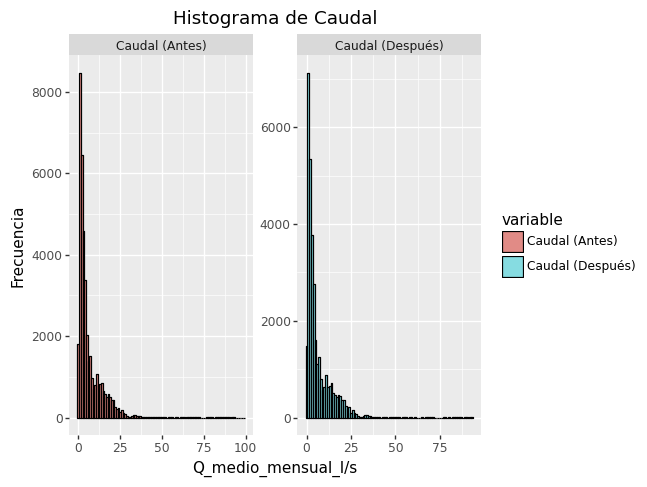

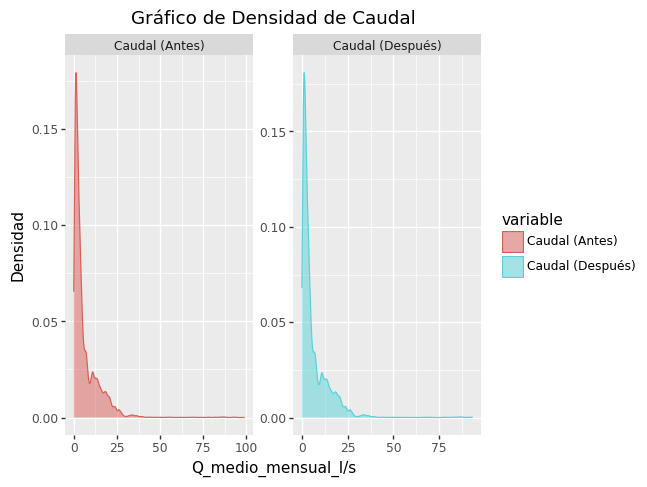

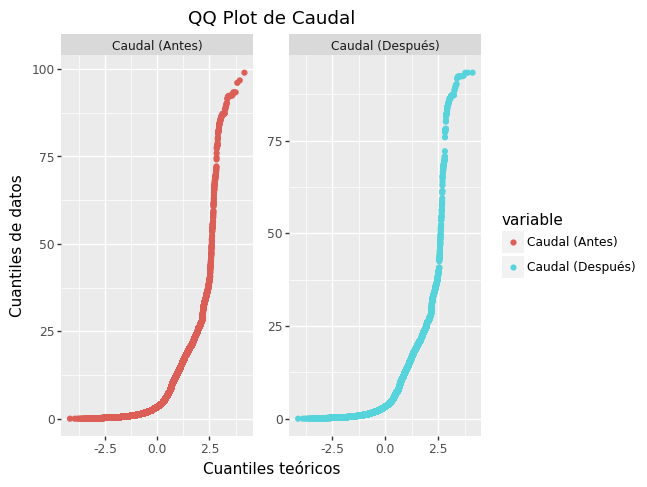

In [28]:
# Datos de caudal antes y después de la detección de outliers
caudal_before = df_train['Q_medio_mensual_l/s']
caudal_after = df_result[df_result['Outlier'] == False]['Caudal_filtrado']

# Combinar los datos en un DataFrame
df = pd.DataFrame({
'Caudal (Antes)': caudal_before,
'Caudal (Después)': caudal_after
})

# Histograma
histogram = (ggplot(df.melt(), aes(x='value', fill='variable')) +
        geom_histogram(binwidth=1, color='black', alpha=0.7) +
        facet_wrap('~variable', scales='free') +
        ggtitle('Histograma de Caudal') +
        xlab('Q_medio_mensual_l/s') +
        ylab('Frecuencia'))

# Gráfico de densidad
density = (ggplot(df.melt(), aes(x='value', fill='variable', color='variable')) +
        geom_density(alpha=0.5) +
        facet_wrap('~variable', scales='free') +
        ggtitle('Gráfico de Densidad de Caudal') +
        xlab('Q_medio_mensual_l/s') +
        ylab('Densidad'))

# QQ Plot
qqplot = (ggplot(df.melt(), aes(sample='value', color='variable')) +
        geom_qq() +
        facet_wrap('~variable', scales='free') +
        ggtitle('QQ Plot de Caudal') +
        xlab('Cuantiles teóricos') +
        ylab('Cuantiles de datos'))

# Mostrar las visualizaciones
print(histogram)
print(density)
print(qqplot)



In [29]:
df_result.head()    

,Pozo,Fecha,Q_medio_mensual_l/s,Trend,Seasonal,Resid,Ruido,Caudal_filtrado,Outlier
0,ARPES-01,2014-01-01,6.658555,6.975376,-0.112310,-0.204510,-0.316821,6.658555,False
1,ARPES-01,2014-02-01,7.717431,7.011750,0.255092,0.450589,0.705682,7.717431,False
2,ARPES-01,2014-03-01,7.663063,7.050837,0.238553,0.373673,0.612226,7.663063,False
3,ARPES-01,2014-04-01,7.573851,7.092853,0.036364,0.444635,0.480999,7.573851,False
4,ARPES-01,2014-05-01,5.465879,7.137536,-0.865926,-0.805732,-1.671657,NaN,True


## 5. Revisión de Resultados para detección de outliers

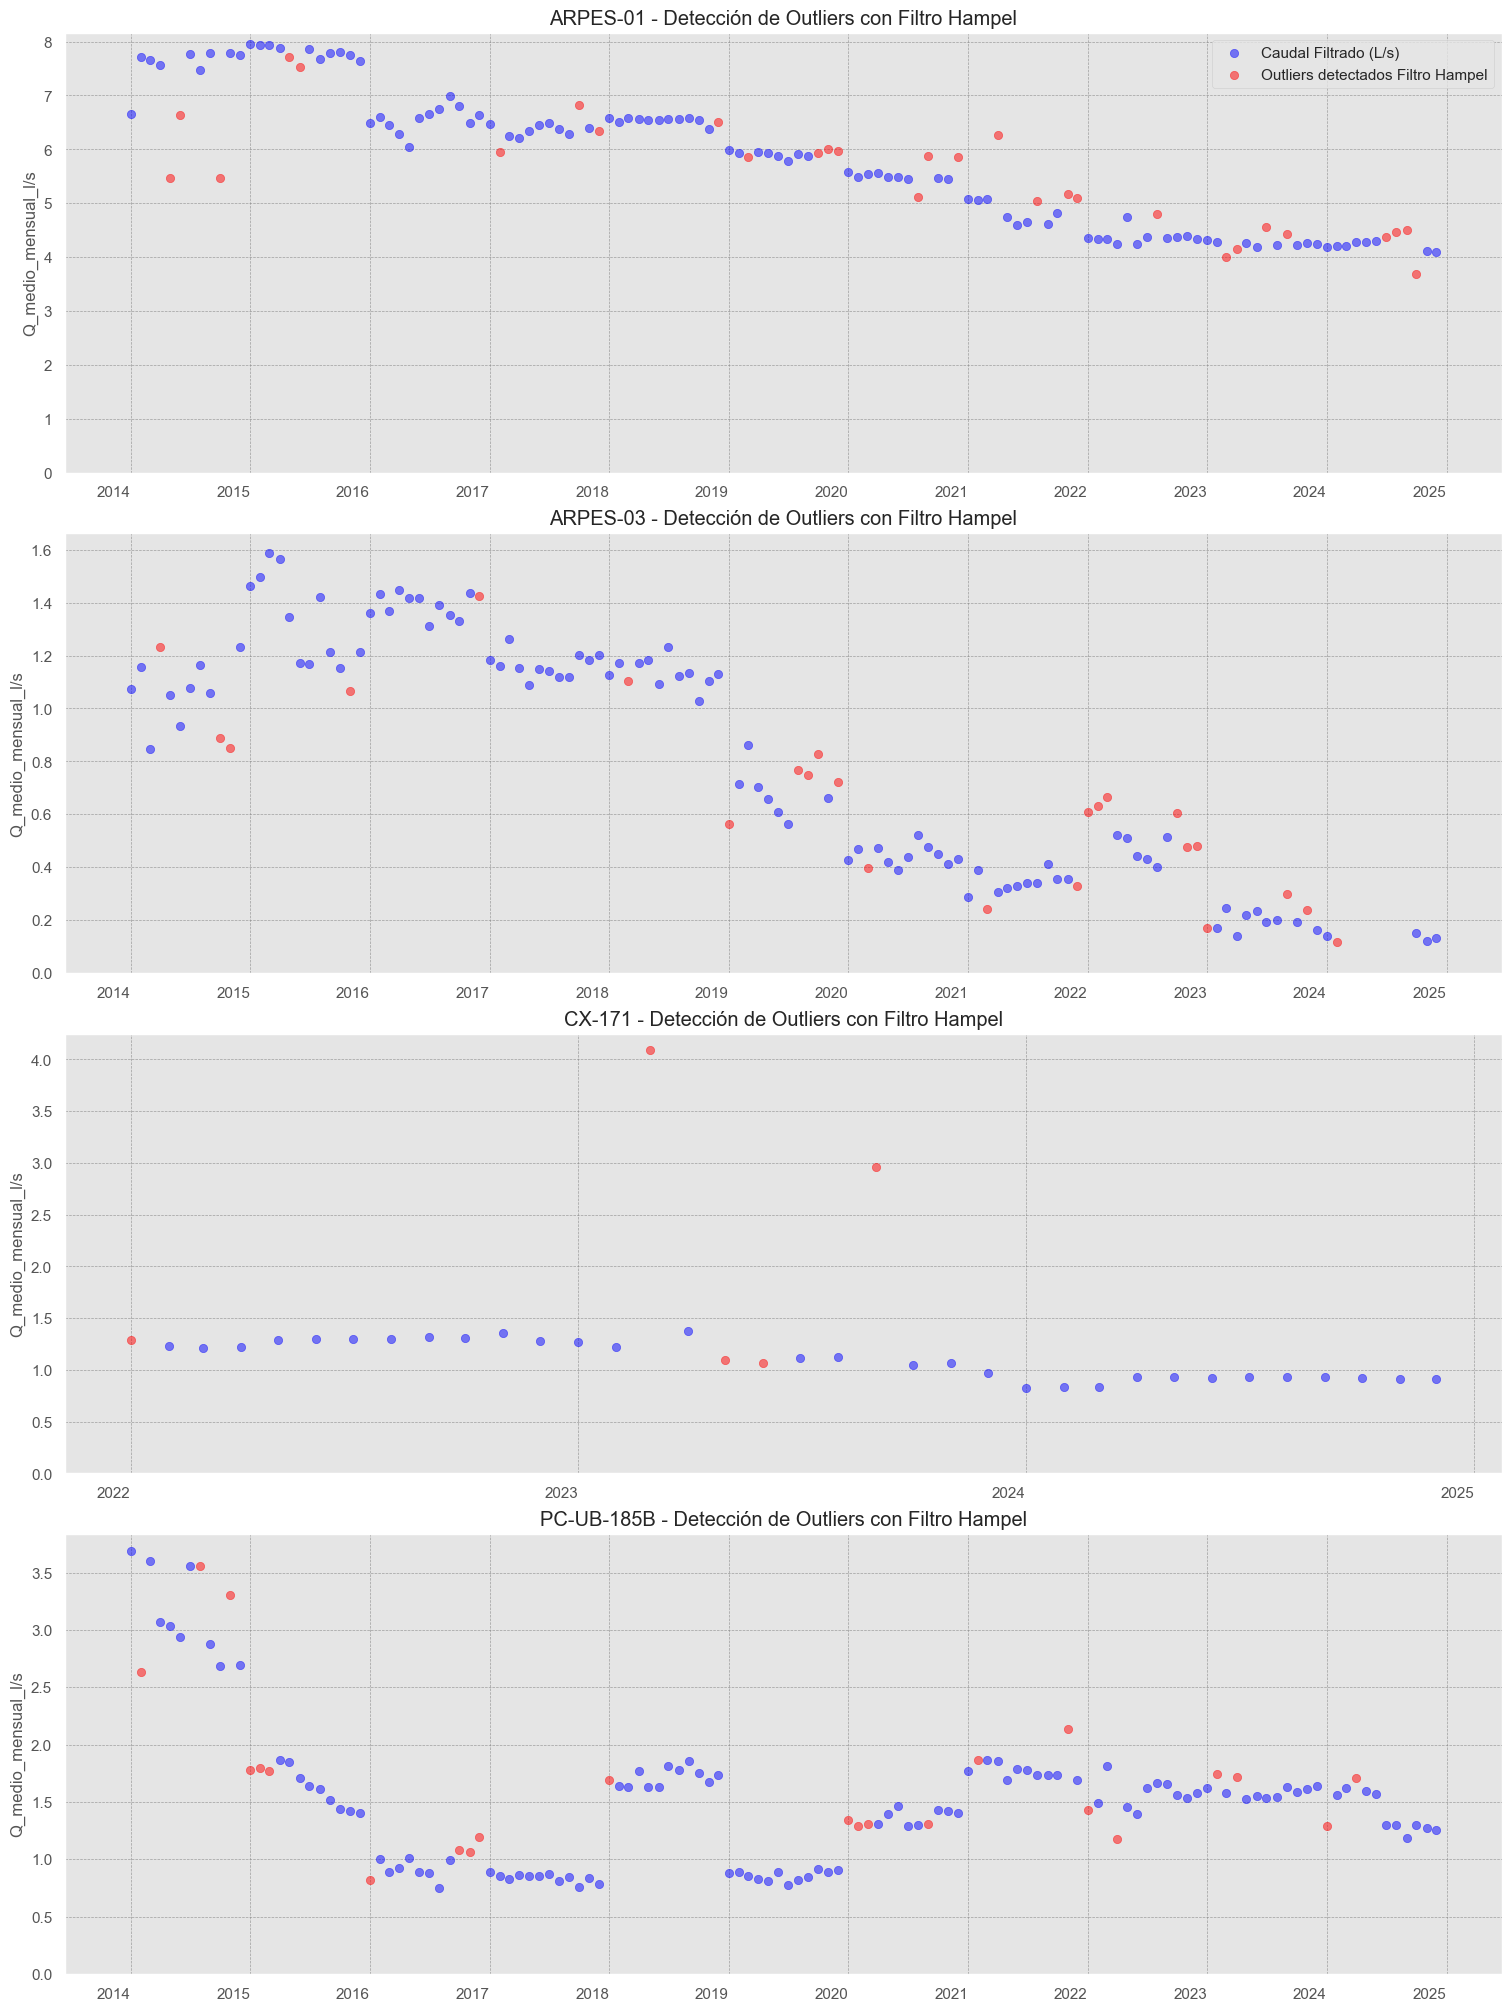

In [33]:
# Activa el estilo 'ggplot'
plt.style.use('ggplot')

# Filtrar el DataFrame por los pozos de interés
pozos = ['ARPES-01', 'ARPES-03', 'CX-171', 'PC-UB-185B']
df_filtrado = df_result[df_result['Pozo'].isin(pozos)]

# Configurar el tamaño de la figura para que cada subplot tenga un aspecto más proporcionado.
fig, axes = plt.subplots(nrows=len(pozos), ncols=1, figsize=(15, 5 * len(pozos)), constrained_layout=True)

# Iterar sobre cada pozo y crear los gráficos.
for i, pozo in enumerate(pozos):
    # Filtramos por el pozo actual.
    df_pozo = df_filtrado[df_filtrado['Pozo'] == pozo]
    df_pozo = df_pozo.set_index('Fecha')  # Asegurarse de que la fecha es el índice para las operaciones de ploteo
    
    # Graficar la serie de tiempo filtrada y los outliers.
    axes[i].scatter(df_pozo.index, df_pozo['Caudal_filtrado'], color='blue', label='Caudal Filtrado (L/s)', alpha=0.5)
    outliers = df_pozo['Outlier'] & df_pozo['Q_medio_mensual_l/s'].notna()
    axes[i].scatter(df_pozo.index[outliers], df_pozo['Q_medio_mensual_l/s'][outliers], color='red', label='Outliers detectados Filtro Hampel', marker='o', alpha=0.5)

    # Configurar las etiquetas y título del gráfico.
    axes[i].set_title(f'{pozo} - Detección de Outliers con Filtro Hampel')
    axes[i].set_ylabel('Q_medio_mensual_l/s')

    # Configurar los formatos de fecha en el eje x.
    axes[i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.MonthLocator()))
    axes[i].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,)))  # Mostrar solo los meses de enero de cada año

    # Ajustar el eje Y para que comience en cero si es necesario.
    axes[i].set_ylim(bottom=0)
    
    # Agregar cuadrícula ligera de color gris.
    axes[i].grid(True, which='both', linestyle='--', linewidth='0.5', color='gray', alpha=0.7)

# Mostrar la leyenda en el primer subplot.
axes[0].legend()

# Ajustar el espaciado entre los subplots para que las etiquetas de fecha no se superpongan.
fig.subplots_adjust(hspace=0.5)

# Rotar las etiquetas de fecha para una mejor lectura en todos los subplots.
for ax in axes:
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='right')

# Mostrar el gráfico.
plt.show()

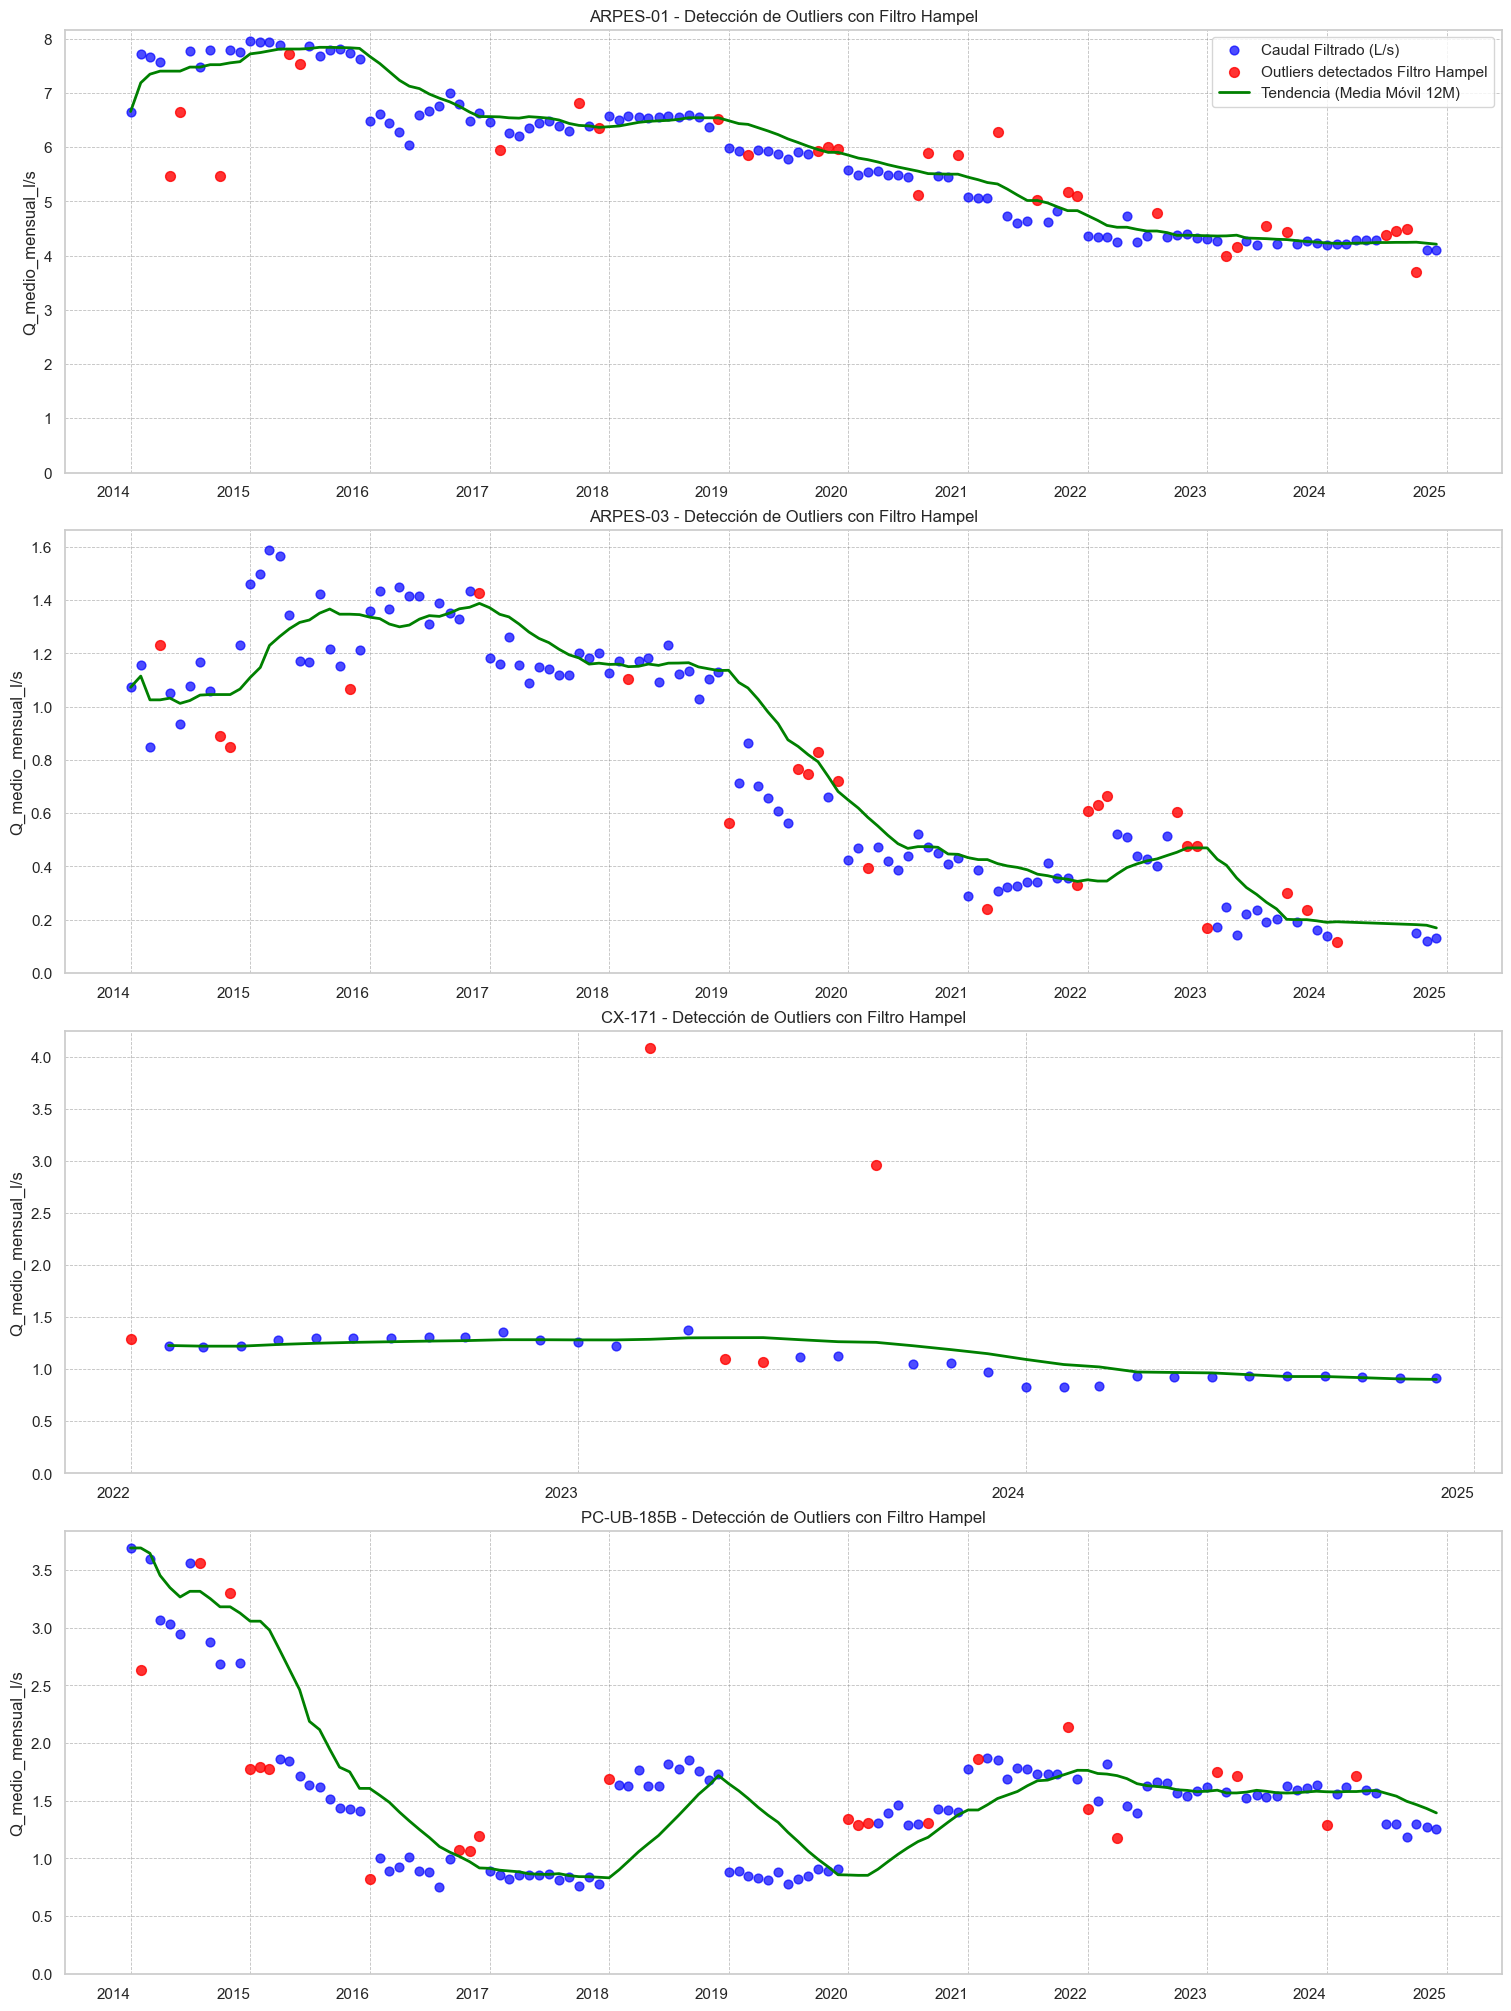

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd

# Activar el estilo 'seaborn-whitegrid'
sns.set(style='whitegrid')

# Filtrar el DataFrame por los pozos de interés
pozos = ['ARPES-01', 'ARPES-03', 'CX-171', 'PC-UB-185B']
df_filtrado = df_result[df_result['Pozo'].isin(pozos)]

# Configurar el tamaño de la figura para que cada subplot tenga un aspecto más proporcionado.
fig, axes = plt.subplots(nrows=len(pozos), ncols=1, figsize=(15, 5 * len(pozos)), constrained_layout=True)

# Iterar sobre cada pozo y crear los gráficos.
for i, pozo in enumerate(pozos):
    # Filtramos por el pozo actual.
    df_pozo = df_filtrado[df_filtrado['Pozo'] == pozo]
    df_pozo = df_pozo.set_index('Fecha')  # Asegurarse de que la fecha es el índice para las operaciones de ploteo
    
    # Calcular la tendencia con una media móvil simple de 12 meses.
    df_pozo['Tendencia'] = df_pozo['Caudal_filtrado'].rolling(window=12, min_periods=1).mean()
    
    # Graficar la serie de tiempo filtrada, los outliers y la tendencia.
    axes[i].scatter(df_pozo.index, df_pozo['Caudal_filtrado'], color='blue', label='Caudal Filtrado (L/s)', s=40, alpha=0.7)
    outliers = df_pozo['Outlier'] & df_pozo['Q_medio_mensual_l/s'].notna()
    axes[i].scatter(df_pozo.index[outliers], df_pozo['Q_medio_mensual_l/s'][outliers], color='red', label='Outliers detectados Filtro Hampel', s=50, alpha=0.8)
    axes[i].plot(df_pozo.index, df_pozo['Tendencia'], color='green', label='Tendencia (Media Móvil 12M)', linewidth=2)
    
    # Configurar las etiquetas y título del gráfico.
    axes[i].set_title(f'{pozo} - Detección de Outliers con Filtro Hampel')
    axes[i].set_ylabel('Q_medio_mensual_l/s')

    # Configurar los formatos de fecha en el eje x.
    axes[i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.MonthLocator()))
    axes[i].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,)))  # Mostrar solo los meses de enero de cada año

    # Ajustar el eje Y para que comience en cero si es necesario.
    axes[i].set_ylim(bottom=0)
    
    # Agregar cuadrícula ligera y sutil.
    axes[i].grid(True, which='both', linestyle='--', linewidth='0.6', color='gray', alpha=0.5)

# Mostrar la leyenda en el primer subplot.
axes[0].legend()

# Ajustar el espaciado entre los subplots para que las etiquetas de fecha no se superpongan.
fig.subplots_adjust(hspace=0.5)

# Rotar las etiquetas de fecha para una mejor lectura en todos los subplots.
for ax in axes:
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='right')

# Mostrar el gráfico.
plt.show()


In [38]:
df_result.head()

,Pozo,Fecha,Q_medio_mensual_l/s,Trend,Seasonal,Resid,Ruido,Caudal_filtrado,Outlier
0,ARPES-01,2014-01-01,6.658555,6.975376,-0.112310,-0.204510,-0.316821,6.658555,False
1,ARPES-01,2014-02-01,7.717431,7.011750,0.255092,0.450589,0.705682,7.717431,False
2,ARPES-01,2014-03-01,7.663063,7.050837,0.238553,0.373673,0.612226,7.663063,False
3,ARPES-01,2014-04-01,7.573851,7.092853,0.036364,0.444635,0.480999,7.573851,False
4,ARPES-01,2014-05-01,5.465879,7.137536,-0.865926,-0.805732,-1.671657,NaN,True


In [41]:
df_result_final=df_result[['Pozo','Fecha','Q_medio_mensual_l/s','Outlier', 'Caudal_filtrado']].copy()
df_result_final

,Pozo,Fecha,Q_medio_mensual_l/s,Outlier,Caudal_filtrado
0,ARPES-01,2014-01-01,6.658555,False,6.658555
1,ARPES-01,2014-02-01,7.717431,False,7.717431
2,ARPES-01,2014-03-01,7.663063,False,7.663063
3,ARPES-01,2014-04-01,7.573851,False,7.573851
4,ARPES-01,2014-05-01,5.465879,True,NaN
...,...,...,...,...,...
41221,XP17-05,2024-06-01,0.274481,False,0.274481
41222,XP17-05,2024-08-01,0.070146,True,NaN
41223,XP17-05,2024-09-01,0.100827,True,NaN
41224,XP17-05,2024-10-01,0.841751,True,NaN


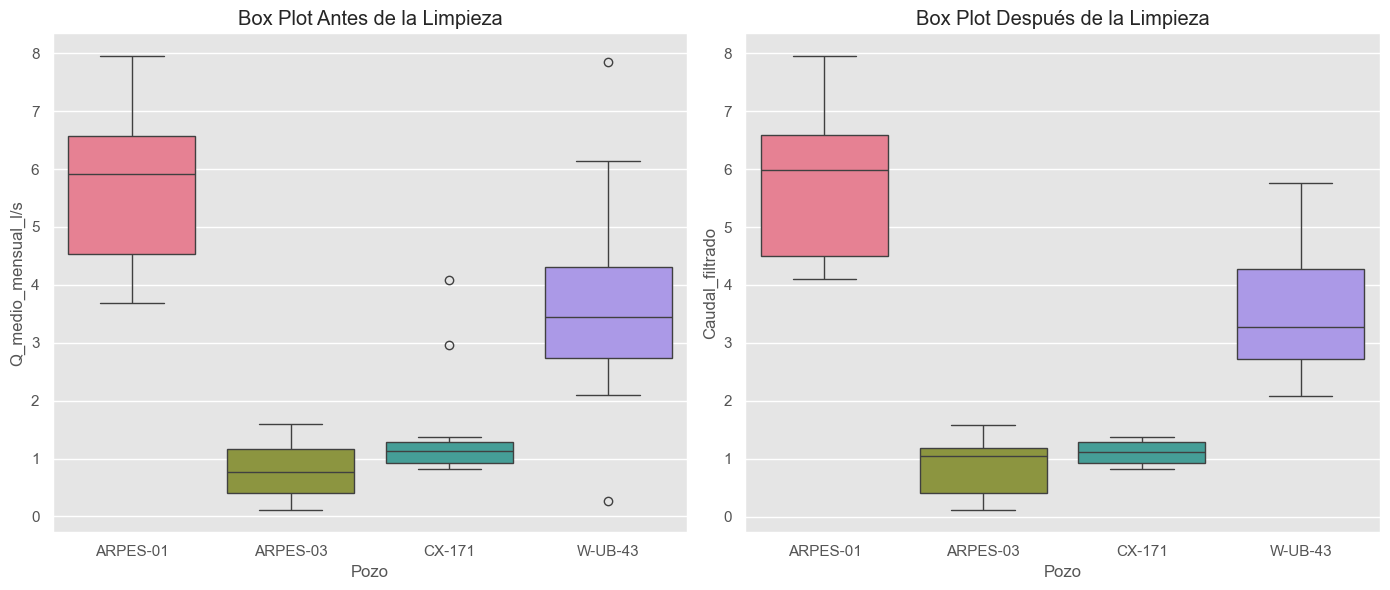

In [53]:
# Generar los box plots
plt.style.use('ggplot')

# Lista de pozos
pozos = ['ARPES-01', 'ARPES-03', 'CX-171', 'W-UB-43']

# Generar la figura
plt.figure(figsize=(14, 6))

# Definir una paleta de colores
palette = sns.color_palette("husl", len(pozos))

# Box Plot antes de la limpieza
plt.subplot(1, 2, 1)
sns.boxplot(x='Pozo', y='Q_medio_mensual_l/s', data=df_result[df_result['Pozo'].isin(pozos)], palette=palette)
plt.title('Box Plot Antes de la Limpieza')

# Box Plot después de la limpieza
df_no_outliers_result = df_result[df_result['Outlier'] == False]
plt.subplot(1, 2, 2)
sns.boxplot(x='Pozo', y='Caudal_filtrado', data=df_no_outliers_result[df_no_outliers_result['Pozo'].isin(pozos)], palette=palette)
plt.title('Box Plot Después de la Limpieza')

# Mostrar los Box Plots
plt.tight_layout()
plt.show()

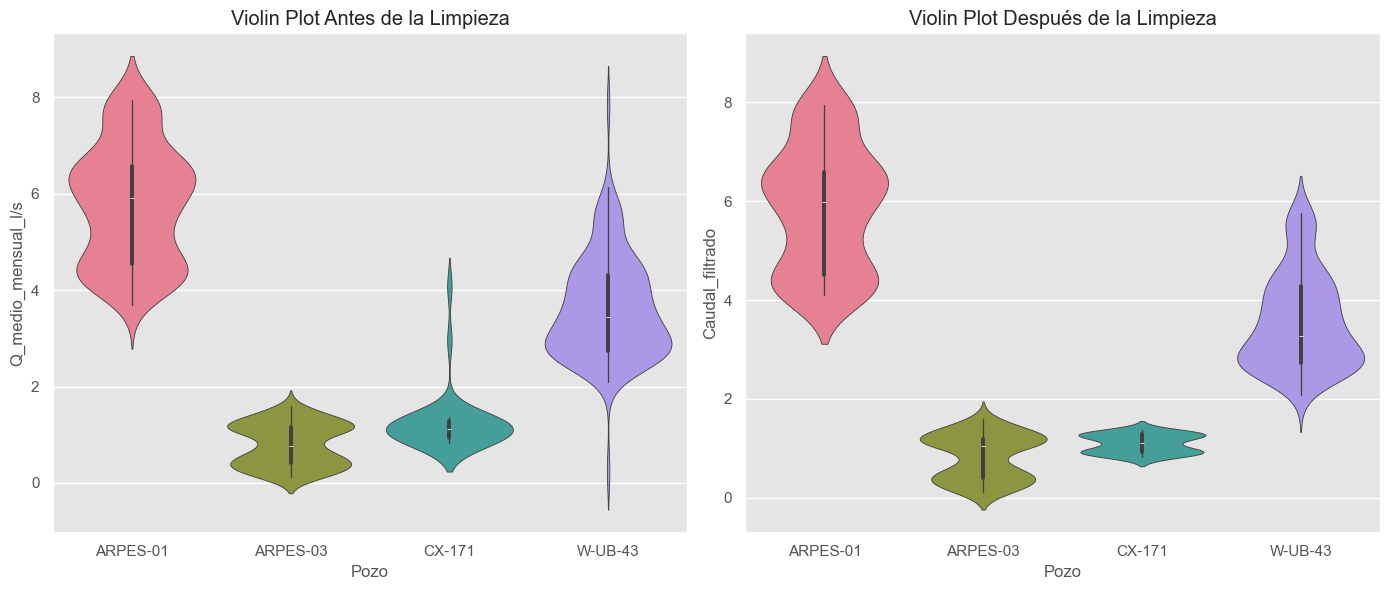

In [54]:
# Generar los violin plots
plt.style.use('ggplot')

# Lista de pozos
pozos = ['ARPES-01', 'ARPES-03', 'CX-171', 'W-UB-43']

# Generar la figura
plt.figure(figsize=(14, 6))

# Definir una paleta de colores
palette = sns.color_palette("husl", len(pozos))

# Violin Plot antes de la limpieza
plt.subplot(1, 2, 1)
sns.violinplot(x='Pozo', y='Q_medio_mensual_l/s', data=df_result[df_result['Pozo'].isin(pozos)], palette=palette)
plt.title('Violin Plot Antes de la Limpieza')

# Violin Plot después de la limpieza
df_no_outliers_result = df_result[df_result['Outlier'] == False]
plt.subplot(1, 2, 2)
sns.violinplot(x='Pozo', y='Caudal_filtrado', data=df_no_outliers_result[df_no_outliers_result['Pozo'].isin(pozos)], palette=palette)
plt.title('Violin Plot Después de la Limpieza')

# Mostrar los Violin Plots
plt.tight_layout()
plt.show()

## 6.- Exporta Archivo resultado

In [42]:
df_result_reset = df_result_final.reset_index()
df_grouped_result_Q = df_result_reset.groupby(['Pozo', df_result_reset['Fecha'].dt.year])['Q_medio_mensual_l/s']
df_describe_Q = df_grouped_result_Q.describe()
print(df_describe_Q)

                count      mean       std       min       25%       50%  \
Pozo     Fecha                                                            
ARPES-01 2014    12.0  7.147245  0.885572  5.461704  6.655109  7.618457   
         2015    12.0  7.788604  0.134295  7.530274  7.701870  7.795128   
         2016    12.0  6.565493  0.245723  6.042637  6.475724  6.598756   
         2017    12.0  6.366669  0.203386  5.945192  6.282884  6.366616   
         2018    12.0  6.540190  0.057732  6.373618  6.535623  6.554380   
...               ...       ...       ...       ...       ...       ...   
XP17-05  2020    12.0  0.409689  0.016351  0.389959  0.396284  0.405874   
         2021    12.0  0.318124  0.044463  0.268312  0.287928  0.310807   
         2022    12.0  0.311147  0.014214  0.274141  0.306928  0.312025   
         2023    12.0  0.296822  0.008433  0.283924  0.291464  0.296765   
         2024    10.0  0.300036  0.213828  0.070146  0.221816  0.262239   

                     75%

In [43]:
df_grouped_result_QF = df_result_reset.groupby(['Pozo', df_result_reset['Fecha'].dt.year])['Caudal_filtrado']
df_describe_QF = df_grouped_result_QF.describe()
print(df_describe_QF)

                count      mean       std       min       25%       50%  \
Pozo     Fecha                                                            
ARPES-01 2014     9.0  7.577176  0.360993  6.658555  7.573851  7.717431   
         2015    10.0  7.822229  0.112681  7.634476  7.756263  7.832514   
         2016    12.0  6.565493  0.245723  6.042637  6.475724  6.598756   
         2017     9.0  6.365427  0.095704  6.215407  6.291568  6.385292   
         2018    11.0  6.542322  0.060052  6.373618  6.545670  6.559197   
...               ...       ...       ...       ...       ...       ...   
XP17-05  2020    12.0  0.409689  0.016351  0.389959  0.396284  0.405874   
         2021     7.0  0.320838  0.012332  0.305792  0.310807  0.319169   
         2022    10.0  0.313485  0.008251  0.303539  0.307738  0.312025   
         2023    10.0  0.297927  0.008676  0.283924  0.293680  0.300231   
         2024     6.0  0.263228  0.033675  0.211238  0.255619  0.262239   

                     75%

In [44]:
df_result_final.head()

,Pozo,Fecha,Q_medio_mensual_l/s,Outlier,Caudal_filtrado
0,ARPES-01,2014-01-01,6.658555,False,6.658555
1,ARPES-01,2014-02-01,7.717431,False,7.717431
2,ARPES-01,2014-03-01,7.663063,False,7.663063
3,ARPES-01,2014-04-01,7.573851,False,7.573851
4,ARPES-01,2014-05-01,5.465879,True,NaN


In [46]:
# Exportar a Excel
with pd.ExcelWriter('Q_Filtrado_STL_Hampel.xlsx', engine='xlsxwriter') as writer:
    df_result_final.to_excel(writer, sheet_name='Result_Final')
    df_describe_Q.to_excel(writer, sheet_name='Estadisticas_Des_Result_Q')
    df_describe_QF.to_excel(writer, sheet_name='Estadisticas_Des_Result_QF')